In [1]:

from sklearn.datasets import make_circles
import torch

#1000 samples
n_samples = 1000

#create circle
x, y = make_circles(n_samples, noise=0.03, random_state=42)

print(f"First 5 samples of X : \n {x[:5]}")
print(f"First 5 samples of Y : \n {y[:5]}")

First 5 samples of X : 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of Y : 
 [1 1 1 1 0]


In [2]:
#Make dataframe of circle data
import pandas as pd

circles = pd.DataFrame({"X1": x[:, 0],
                        "X2": x[:, 1],
                        "labels": y})
circles.head(10)

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [ ]:
#visualize
import matplotlib.pyplot as plt

plt.scatter(x=x[:, 0], y=x[:, 1], c=y, cmap=plt.cm.RdYlBu)


Check input output shapes

In [ ]:
x.shape, y.shape

In [ ]:
#View feature and labels
x_sample = x[0]
y_sample = y[0]

#data into tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x[:5], y[:5]

In [ ]:
torch.manual_seed(42)
#split into training and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
len(x_train), len(x_test), len(y_train), len(y_test)

In [ ]:
#building model
import torch
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class CircleModelv0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer2(self.layer1(x))  #x->layer1->layer2->output


model1 = CircleModelv0().to(device)
model1.state_dict()

In [ ]:
next(model1.parameters())
model1.state_dict()


In [ ]:
#using sequential

model1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

model1.state_dict()

In [ ]:
with torch.inference_mode():
    untrained_pred = model1(x_test.to(device))
print(f"Length of prediction: {len(untrained_pred)}, Shape: {untrained_pred.shape}")
print(f"Length of test sample: {len(x_test)}, Shape: {x_test.shape}")
print(f"\nFirst 10 prediction: {untrained_pred[:10]}")
print(f"\nFirst 10 label: {y_test[:10]}")

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [ ]:
#calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [ ]:
#Train Model
#raw logits -> prediction probabilities -> predictiom labels

model1.eval()
with torch.inference_mode():
    y_logits = model1(x_test.to(device))[:5]
print(y_logits)

In [ ]:
#logits turn into prediction probabilities

y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs)

In [ ]:
#find prediction labels
y_pred = torch.round(y_pred_probs)
y_pred_label = torch.round(torch.sigmoid(model1(x_test.to(device))[:5]))
print(torch.eq(y_pred.squeeze(), y_pred_label.squeeze()))
y_pred.squeeze()

In [ ]:
torch.cuda.manual_seed(42)
epochs = 100
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model1.train()

    y_logits = model1(x_train.to(device)).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #    loss = loss_fn(torch.sigmoid(y_logits), y_pred)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model1.eval()
    with torch.inference_mode():
        test_logits = model1(x_test.to(device)).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.5f}, Accuracy: {acc:.2f}, Test accuracy: {test_acc:.2f}")

In [ ]:
#prediction vialise
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


In [ ]:
from FRAME.PYTORCH.helper_functions import plot_predictions, plot_decision_boundary

#plot descsion boudnary of a model
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model1, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model1, x_test, y_test)

Imporving


In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)  # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CircleModelV1().to(device)
model_1

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()  # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000  # Train for longer

# Put data to target device
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model1, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model1, x_test, y_test)

In [ ]:
#trying this model on straight line
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

x_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * x_regression + bias


In [ ]:
train_split = int(0.8 * len(x_regression))
x_train_regression, y_train_regression = x_regression[:train_split], y_regression[:train_split]
x_test_regression, y_test_regression = x_regression[train_split:], y_regression[train_split:]

In [ ]:
plot_predictions(train_data=x_train_regression,
                 train_labels=y_train_regression,
                 test_data=x_test_regression,
                 test_labels=y_test_regression
                 );

In [ ]:
model2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model2

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1400

# Put data to target device
x_train_regression, y_train_regression = x_train_regression.to(device), y_train_regression.to(device)
x_test_regression, y_test_regression = x_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model2(x_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model2(x_test_regression)
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

In [ ]:
# Turn on evaluation mode
model2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model2(x_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=x_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=x_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42,
                    )

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [ ]:
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

X_train[:5], y_train[:5]

In [ ]:
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
print(model_3)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)
epochs = 1100

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)  # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))  # logits -> prediction probabilities -> prediction labels
        # 2. Calculate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)  # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)  # model_3 = has non-linearity

Multiclass classification


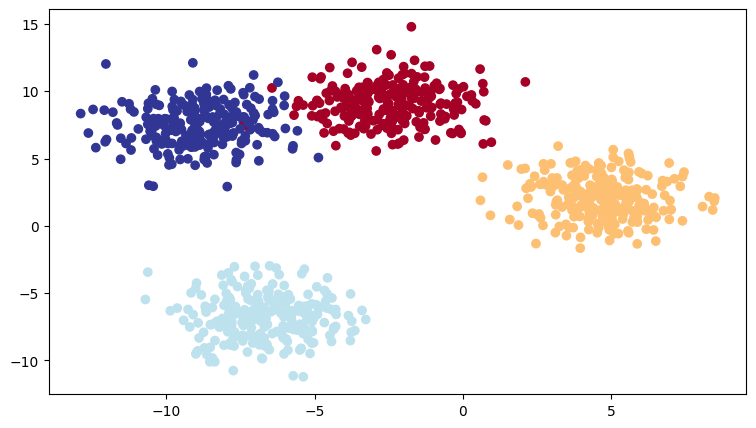

In [3]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#hyperparameters
num_class = 4
num_features = 2
random_seed = 42

#create multiclass data
x_blob, y_blob = make_blobs(n_samples=1000, n_features=num_features, random_state=random_seed, centers=num_class,
                            cluster_std=1.5)

# data into tensor
x_blob, y_blob = (torch.from_numpy(x_blob).type(torch.float),
                  torch.from_numpy(y_blob).type(torch.LongTensor))

#split into training and test
x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob, y_blob, test_size=0.2,
                                                                        random_state=random_seed)

#plot
plt.figure(figsize=(9, 5))
plt.scatter(x_blob[:, 0], x_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_features=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


model4 = BlobModel(input_features=2, output_features=4, hidden_features=8).to(device)
model4

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model4.parameters(),
                            lr=0.1)

In [ ]:
print(model4(x_blob_train.to(device))[0].shape, num_class)
print(model4(x_blob_train.to(device))[:5])

In [ ]:
# Make prediction logits with model
y_logits = model4(x_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 15

# Put data to target device
X_blob_train, y_blob_train = x_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = x_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model4.train()

    # 1. Forward pass
    y_logits = model4(X_blob_train)  # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(
        dim=1)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model4.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_pred)

    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

In [ ]:
# Make predictions
model4.eval()
with torch.inference_mode():
    y_logits = model4(X_blob_test)

# View the first 10 predictions
print(y_logits[:10])

In [ ]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_pred_probs[:10])

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model4, X_blob_test, y_blob_test)

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import Accuracy
# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_pred_probs, y_blob_test)